In [1]:
## data is taken from The Movie Database (TMDb)

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

df = pd.read_csv("movie_data.csv", index_col=0)

df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [3]:
df['profitable'] = df.revenue > df.budget
df['profitable'] = df['profitable'].astype(int)

regression_target = 'revenue' 
classification_target = 'profitable' 

df['profitable'].value_counts()

1    2585
0    2218
Name: profitable, dtype: int64

In [4]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(how="any")   ## for simplicity

df.shape

(1406, 23)

In [5]:
# indicator columns for each genre

list_genres = df.genres.apply(lambda x: x.split(","))
genres = []
for row in list_genres:
    row = [genre.strip() for genre in row]
    for genre in row:
        if genre not in genres:
            genres.append(genre)

for genre in genres:
    df[genre] = df['genres'].str.contains(genre).astype(int)

df[genres].head()

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,War,History,Music,Documentary,TV Movie,Foreign
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


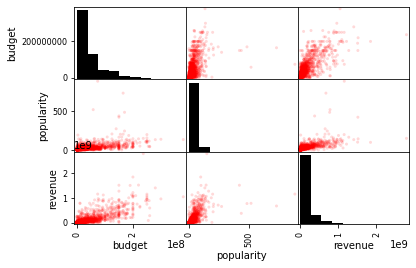

budget          1.754872
popularity      7.968139
runtime         1.059804
vote_count      2.461041
vote_average   -1.080038
revenue         3.084680
profitable     -1.081030
dtype: float64


In [6]:
continuous_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']
outcomes_and_continuous_covariates = continuous_covariates + [regression_target, classification_target]
plotting_variables = ['budget', 'popularity', regression_target]

axes = pd.plotting.scatter_matrix(df[plotting_variables], alpha=0.15, \
       color=(0,0,0), hist_kwds={"color":(0,0,0)}, facecolor=(1,0,0))

plt.show()

print(df[outcomes_and_continuous_covariates].skew())

In [7]:
# It appears that the variables budget, popularity, runtime, vote_count, and revenue are all right-skewed. 
# Therefore,transform these variables to eliminate this skewness

for covariate in ['budget', 'popularity', 'runtime', 'vote_count', 'revenue']:
    df[covariate] = df[covariate].apply(lambda x: np.log10(1+x))
    
print(df[outcomes_and_continuous_covariates].skew())

budget         -2.816990
popularity     -0.431543
runtime         0.530489
vote_count     -0.677632
vote_average   -1.080038
revenue        -2.177372
profitable     -1.081030
dtype: float64


In [8]:
df.to_csv("movies_clean.csv")

In [9]:
df2 = pd.read_csv('movies_clean.csv')
df2.head()

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,Comedy,Romance,Horror,Mystery,War,History,Music,Documentary,TV Movie,Foreign
0,0,8.374748,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",2.180234,...,0,0,0,0,0,0,0,0,0,0
1,1,8.477121,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",2.146384,...,0,0,0,0,0,0,0,0,0,0
2,2,8.389166,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,2.034936,...,0,0,0,0,0,0,0,0,0,0
3,3,8.397940,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,2.054280,...,0,0,0,0,0,0,0,0,0,0
4,4,8.414973,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",1.652507,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Define all covariates and outcomes from `df`.
regression_target = 'revenue'
classification_target = 'profitable'
all_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average', 'Action', 'Adventure', 'Fantasy', 
                  'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 
                  'Horror', 'Mystery', 'War', 'History', 'Music', 'Documentary', 'TV Movie', 'Foreign']

regression_outcome = df2[regression_target]
classification_outcome = df2[classification_target]
covariates = df2[all_covariates]

# Instantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)

In [11]:
def correlation(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return r2_score(y, predictions)
    
def accuracy(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return accuracy_score(y, predictions)

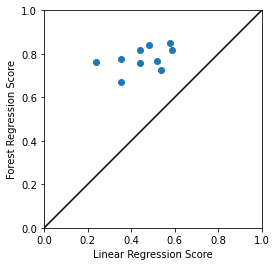

In [12]:
# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

plt.show()

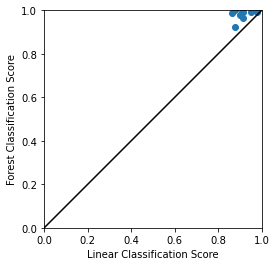

In [13]:
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

plt.show()


In [15]:
positive_revenue_df2 = df2[df2["revenue"] > 0]

# Replace the dataframe in the following code, and run.

regression_outcome = positive_revenue_df2[regression_target]
classification_outcome = positive_revenue_df2[classification_target]
covariates = positive_revenue_df2[all_covariates]

# Reinstantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

np.mean(forest_regression_scores)

0.7680846546233253

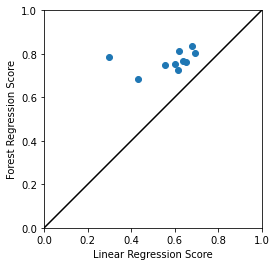

[('Fantasy', 0.0),
 ('Music', 0.0),
 ('TV Movie', 0.0),
 ('Foreign', 0.0),
 ('Documentary', 5.0242102884089965e-05),
 ('Romance', 6.604583330721586e-05),
 ('Western', 0.00015626864826347376),
 ('Thriller', 0.00015821728190237307),
 ('Mystery', 0.00018214788588276072),
 ('Horror', 0.00020010584158045155),
 ('War', 0.00021568794173586987),
 ('Action', 0.00039731194014744624),
 ('History', 0.0004223908705396497),
 ('Family', 0.0004586994511166151),
 ('Comedy', 0.0005068269265224419),
 ('Animation', 0.0009318004228486637),
 ('Science Fiction', 0.0009980285384426231),
 ('Crime', 0.0010130985717443698),
 ('Drama', 0.0013281289930065158),
 ('Adventure', 0.003080303040107078),
 ('vote_average', 0.006646714634639983),
 ('runtime', 0.016135965006071718),
 ('popularity', 0.08355296569387499),
 ('budget', 0.30757299732366344),
 ('vote_count', 0.5759260530517182)]

In [16]:
# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

plt.show()

# Print the importance of each covariate in the random forest regression.
forest_regression.fit(covariates, regression_outcome)    
sorted(list(zip(all_covariates, forest_regression.feature_importances_)), key=lambda tup: tup[1])

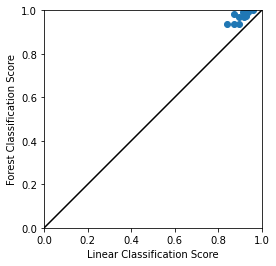

[('TV Movie', 0.0),
 ('Horror', 0.001715202327676785),
 ('Animation', 0.0019388197444951466),
 ('Comedy', 0.0022574689899296065),
 ('Foreign', 0.0022801352325337114),
 ('Documentary', 0.002846458591904433),
 ('Romance', 0.0031608732977368944),
 ('Thriller', 0.0035569898966812397),
 ('Mystery', 0.004282452349394276),
 ('Music', 0.004308655018573079),
 ('Fantasy', 0.0051937079152913745),
 ('Western', 0.005480591973153852),
 ('Family', 0.0066609392542522055),
 ('Crime', 0.006772395781754328),
 ('History', 0.006793172805113654),
 ('Action', 0.0073412694021133835),
 ('Adventure', 0.007596959755592538),
 ('Science Fiction', 0.010816587516514861),
 ('War', 0.011275947022575308),
 ('Drama', 0.023093574562804687),
 ('runtime', 0.04154729351420867),
 ('budget', 0.08765680648089587),
 ('vote_average', 0.10261105225795153),
 ('popularity', 0.2811360280003983),
 ('vote_count', 0.36967661830845444)]

In [17]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

plt.show()

# Print the importance of each covariate in the random forest classification.
forest_classifier.fit(covariates, classification_outcome)
sorted(list(zip(all_covariates, forest_classifier.feature_importances_)), key=lambda tup: tup[1])